# Python EDA & GBTRegrssion Evaluation

### Imports

In [1]:
import os
import glob
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

### Helper Functions

In [137]:
# Read Multiple CSVs
def read_csvs(dir_path):
    files_in_dir = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
    for filenames in files_in_dir:
        df = pd.read_csv(filenames)
        df.to_csv('out.csv', mode='a')
    df = pd.read_csv('out.csv')
    os.remove("out.csv")
    return df

def read_csv(path, cols):
    files = os.listdir(path) # IPython magic
    f = lambda x: x.endswith(('.csv'))
    file = path+files[[f(x) for x in files].index(True)]
    print(file)
    return pd.read_csv(file, names=cols)

# Confusion Matrix to DataFrame
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)

def pre_process(df):
    df["route"] = df["origin"] + " to " + df["dest"]
    return df

### Read "pre_process" and GBTRegressor results tables

In [64]:
cols_gbt = ["taxi_time", "air_delay_time", "delay_time", "cancelled", "year", "month", "day_of_month", "day_of_week", "fl_date", "weekday", 
            "x_fl_date_moy", "y_fl_date_moy", "x_fl_date_woy", "y_fl_date_woy", "x_fl_date_dow", "y_fl_date_dow", "unique_carrier", 
            "fl_num", "taxi_ind", "delay_ind", "origin", "dest", "dep_del15", "arr_del15", "arr_delay_group", "dep_delay_group", 
            "x_whls_on_mod", "y_whls_on_mod", "x_whls_off_mod", "y_whls_off_mod", "flights", "distance", "distance_group", 
            "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay", "delay_cause", 
            "taxi_time_bkidx", "delay_time_bkidx", "air_delay_time_bkidx", 
            "taxi_time_bkt", "delay_time_bkt", "air_delay_time_bkt", "prediction"]
cols_pp = cols_gbt[:-1]

path_gbt = "tables/gbt/gbt.csv/"
path_pp = "tables/pre_process/pre_process.csv/"

gbtdf = pre_process(read_csv(path_gbt, cols_gbt))
ppdf = pre_process(read_csv(path_pp, cols_pp))

tables/gbt/gbt.csv/part-00000-33d77948-d278-4477-a782-2b3aba83697f.csv
tables/pre_process/pre_process.csv/part-00000-0583fb8c-a691-4e7d-acda-8a217041d579.csv


In [27]:
ppdf.shape

(103485, 47)

### Plots

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


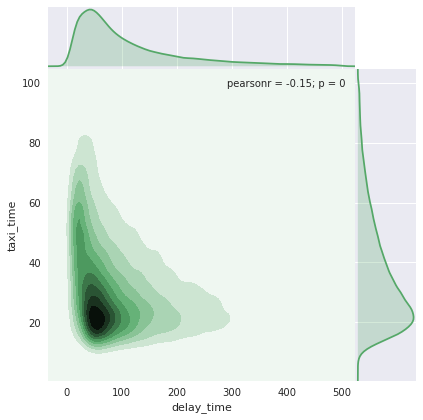

In [201]:
g = sns.jointplot("delay_time", "taxi_time", data=ppdf[(ppdf["taxi_time"] < 100) & (ppdf["delay_time"] < 500)],
                  kind="kde", space=0, color="g")

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


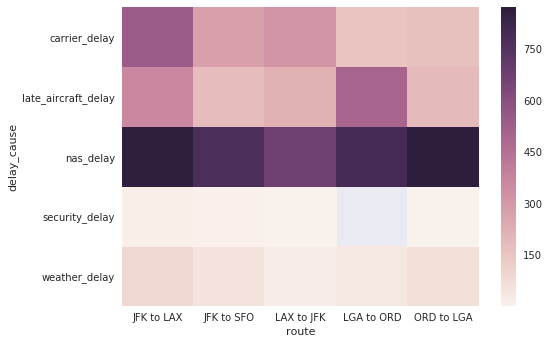

In [176]:
def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)
processed, time_ind = time_ind(ppdf.sort_values(["taxi_time_bkidx"]), "taxi_time", 30)
select = ppdf[[time_ind, "delay_cause","route"]]
aggragate = select.groupby(['delay_cause', 'route'])[time_ind].sum().reset_index()
condition = aggragate[aggragate[time_ind] > 600]["route"]
filtered = aggragate[aggragate['route'].isin(condition)]
result = filtered.pivot("delay_cause", 'route', time_ind)
ax = sns.heatmap(result)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


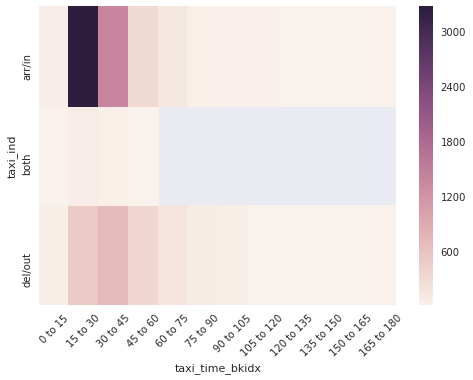

In [260]:
def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)
processed, time_ind = time_ind(ppdf, "delay_time", 30)
aggragate1 = processed.groupby(["taxi_ind", "taxi_time_bkidx", "taxi_time_bkt", "route"]
                              )[time_ind].sum().reset_index()
condition = aggragate1[aggragate1[time_ind] > 600]["route"]
filtered = aggragate1[aggragate1['route'].isin(condition)]
select = filtered[[time_ind, "taxi_ind", "taxi_time_bkidx", "taxi_time_bkt"]]
aggragate2 = select.groupby(["taxi_ind", "taxi_time_bkidx"])[time_ind].sum().reset_index()
result = aggragate2.pivot("taxi_ind", "taxi_time_bkidx", time_ind)
ax = sns.heatmap(result)

xticks = select[["taxi_time_bkidx", "taxi_time_bkt"]
               ].sort_values(["taxi_time_bkidx"]
                            ).drop_duplicates('taxi_time_bkidx'
                                             )["taxi_time_bkt"]

ax.set_xticklabels(xticks)
# plt.title('Congestion Time - Delay Type Heatmap')
plt.setp(plt.xticks()[1], rotation=45)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


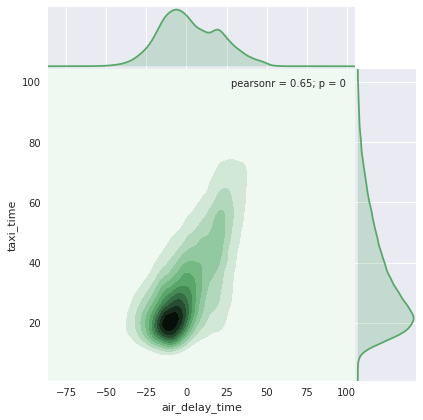

In [259]:
g = sns.jointplot("air_delay_time", "taxi_time", data=ppdf[(ppdf["taxi_time"] < 100) & (ppdf["nas_delay"] < 50)],
                  kind="kde", space=0, color="g")
# plt.title('Air Delay Time - Congestion Time KDE Plot')
# plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


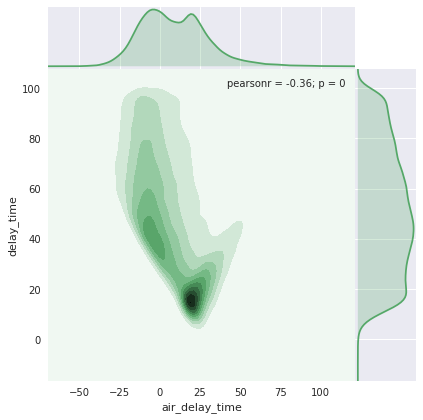

In [257]:
g = sns.jointplot("air_delay_time", "delay_time", data=ppdf[(ppdf["air_delay_time"] < 250) & (ppdf["delay_time"] < 100)],
                  kind="kde", space=0, color="g")
# plt.title('Air Delay Time - Delay Time KDE Plot')
# plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


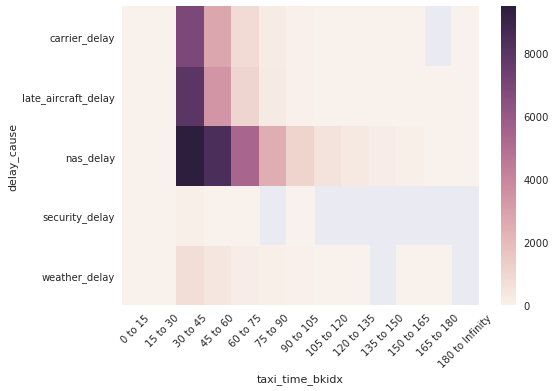

In [258]:
def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)
processed, time_ind = time_ind(ppdf, "taxi_time", 30)
select = ppdf[[time_ind, "delay_cause", "taxi_time_bkt", "taxi_time_bkidx"]]
aggragate = select.groupby(['delay_cause', "taxi_time_bkidx"])[time_ind].sum().reset_index()
result = aggragate.pivot("delay_cause", "taxi_time_bkidx", time_ind)
ax = sns.heatmap(result)

xticks = select[["taxi_time_bkidx", "taxi_time_bkt"]
               ].sort_values(["taxi_time_bkidx"]
                            ).drop_duplicates('taxi_time_bkidx'
                                             )["taxi_time_bkt"]

ax.set_xticklabels(xticks)
plt.setp(plt.xticks()[1], rotation=45)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


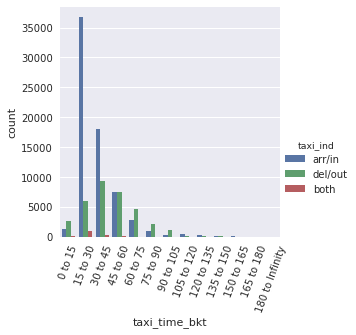

In [247]:
def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)
g = sns.factorplot(x="taxi_time_bkt", hue="taxi_ind",
                   data=ppdf.sort_values(["taxi_time_bkidx"]), kind="count")
plt.setp(plt.xticks()[1], rotation=70)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


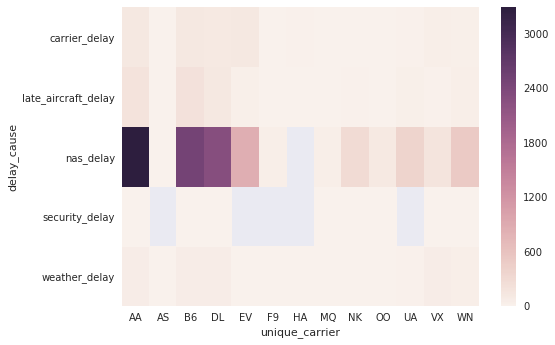

In [249]:
# ax = sns.violinplot(x="unique_carrier", y="air_delay_time", hue="delay_ind",
#                     data=ppdf, palette="muted")

def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] > n
    return (df, col)
processed, time_ind = time_ind(ppdf, "air_delay_time", 30)
select = ppdf[[time_ind, "delay_cause", "unique_carrier"]]
aggragate = select.groupby(['delay_cause', "unique_carrier"])[time_ind].sum().reset_index()
result = aggragate.pivot("delay_cause", "unique_carrier", time_ind)
ax = sns.heatmap(result)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


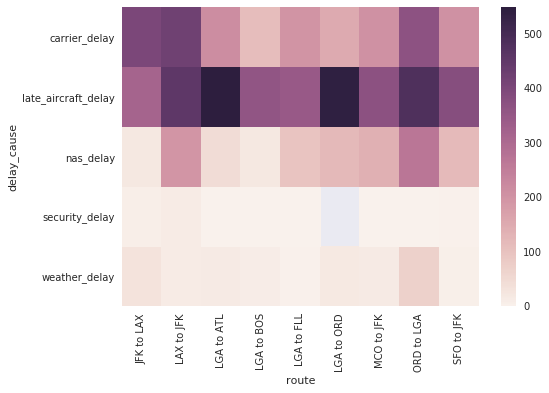

In [195]:
def time_ind(df, x, n):
    col = "{name}{time}_ind".format(name=x, time=n)
    df[col] = df[x] < n
    return (df, col)
processed, time_ind = time_ind(ppdf, "air_delay_time", 0)
select = ppdf[[time_ind, "delay_cause", "route"]]
aggragate = select.groupby(['delay_cause', "route"])[time_ind].sum().reset_index()
condition = aggragate[aggragate[time_ind] > 300]["route"]
filtered = aggragate[aggragate['route'].isin(condition)]
result = filtered.pivot("delay_cause", "route", time_ind)
ax = sns.heatmap(result)

In [261]:
bins = [0, 7.0, 20.0, 33.0, 46.0, 59.0, 72.0, 85.0, 98.0, 111.0, 124.0, 137.0, 150.0, 163.0, 176.0, float("inf")]
group_names = ['0-7', '7-20', '20-33', '33-46', '46-59', '59-72', '72-85', '85-98', '98-111', '111-124', '124-137',
              '137-150', '150-163', '163-176', '176-Inf']
gbtdf['label_cats'] = pd.cut(gbtdf['taxi_time'], bins, labels=group_names)
gbtdf['pred_cats'] = pd.cut(gbtdf['prediction'], bins, labels=group_names)
from sklearn.metrics import classification_report, confusion_matrix
res = gbtdf
print(classification_report(gbtdf['label_cats'],gbtdf['pred_cats'],target_names=group_names))

cm = confusion_matrix(gbtdf['label_cats'],gbtdf['pred_cats'])
cm2df(cm, group_names)

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0-7       0.00      0.00      0.00         1
       7-20       0.23      0.15      0.18        78
      20-33       0.46      0.35      0.40        72
      33-46       0.25      0.25      0.25        20
      46-59       0.00      0.00      0.00        15
      59-72       0.00      0.00      0.00         6
      72-85       0.00      0.00      0.00         1
      85-98       0.54      0.67      0.60      7350
     98-111       0.37      0.44      0.40      4276
    111-124       0.34      0.40      0.37      2471
    124-137       0.34      0.25      0.29      1364
    137-150       0.76      0.32      0.45      4174
    150-163       0.23      0.24      0.24       609
    163-176       0.25      0.08      0.12       287
    176-Inf       0.20      0.02      0.04       146

avg / total       0.49      0.47      0.46     20870



,0-7,7-20,20-33,33-46,46-59,59-72,72-85,85-98,98-111,111-124,124-137,137-150,150-163,163-176,176-Inf
0-7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7-20,0,12,8,2,0,0,0,0,1,4,7,0,29,12,3
20-33,0,13,25,6,2,0,0,0,0,2,4,0,13,5,2
33-46,0,1,5,5,0,0,0,0,0,3,0,0,1,3,2
46-59,0,3,3,3,0,0,0,0,0,3,0,0,3,0,0
59-72,0,0,3,2,0,0,0,0,0,0,1,0,0,0,0
72-85,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
85-98,0,0,0,0,0,0,0,4961,1579,341,40,397,30,2,0
98-111,0,0,1,0,0,0,0,1496,1863,744,107,25,35,5,0
111-124,0,1,0,0,0,0,0,229,935,995,226,1,77,7,0


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


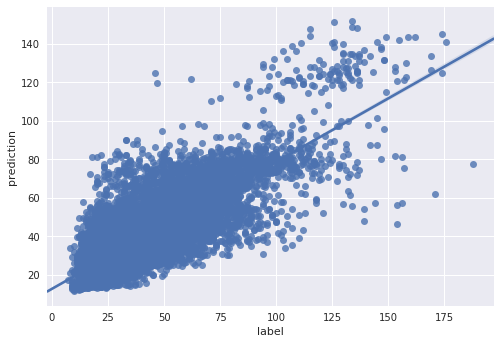

In [43]:
ax = sns.regplot(x="label", y="prediction", data=gbtdf)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


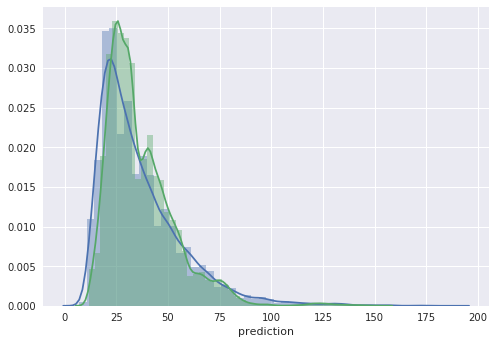

In [265]:
ax1 = sns.distplot(gbtdf["taxi_time"])
ax2 = sns.distplot(gbtdf["prediction"]) #green